In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from shutil import copy
import os
import cv2 as cv

%matplotlib inline

In [4]:
# ROOT_DIR = os.curdir

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [5]:
ROOT_DIR = '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/'
WORKING_DIR = '/kaggle/working/'

train_dir = os.path.join(WORKING_DIR, 'train')
valid_dir = os.path.join(WORKING_DIR, 'valid')

# for dir_ in [train_dir, valid_dir]:
#     os.makedirs(dir_)
    
train_with_mask = os.path.join(train_dir, 'with_mask')
train_without_mask = os.path.join(train_dir, 'without_mask')
valid_with_mask = os.path.join(valid_dir, 'with_mask')
valid_without_mask = os.path.join(valid_dir, 'without_mask')

for dir_ in [train_with_mask, train_without_mask, valid_with_mask, valid_without_mask]:
    os.makedirs(dir_)

In [6]:
# copying file from the root directory

for file in os.listdir(os.path.join(ROOT_DIR, 'Train/WithMask')):
    copy(os.path.join(ROOT_DIR, 'Train/WithMask', file), os.path.join(train_with_mask, file))
    
for file in os.listdir(os.path.join(ROOT_DIR, 'Train/WithoutMask')):
    copy(os.path.join(ROOT_DIR, 'Train/WithoutMask', file), os.path.join(train_without_mask, file))

for file in os.listdir(os.path.join(ROOT_DIR, 'Validation/WithMask')):
    copy(os.path.join(ROOT_DIR, 'Validation/WithMask', file), os.path.join(valid_with_mask, file))

for file in os.listdir(os.path.join(ROOT_DIR, 'Validation/WithoutMask')):
    copy(os.path.join(ROOT_DIR, 'Validation/WithoutMask', file), os.path.join(valid_without_mask, file))

In [7]:
train_mask_dir = os.path.join(WORKING_DIR, 'train')
valid_mask_dir = os.path.join(WORKING_DIR, 'valid')

In [8]:
len(os.listdir(os.path.join(valid_mask_dir, 'with_mask')))

400

In [9]:

def train_val_generator(training_dir, validation_dir):
    """
        Creates the training and validation generators
        
        Args:
        training_dir (string): directory path containing the training images
        validation_dir (string): directory path containing the validation images
        
        returns train_generator, validation_generator
    """
    
    train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    rotation_range=60,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest',
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    vertical_flip=True
                      )
    
    train_generator = train_datagen.flow_from_directory(training_dir, 
                                                        batch_size=12, 
                                                        class_mode='binary', 
                                                        target_size=(150,150))
    
    valid_datagen = ImageDataGenerator(rescale=1./255,)
    
    validation_generator = valid_datagen.flow_from_directory(validation_dir, 
                                                             batch_size=12, 
                                                             class_mode='binary', 
                                                             target_size=(150, 150))
    
    return train_generator, validation_generator

In [10]:
train_generator, valid_generator = train_val_generator(train_mask_dir, valid_mask_dir)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [11]:
from keras.applications.inception_v3 import InceptionV3

def pretrained_model():
    pretrained_model = InceptionV3(input_shape=(150, 150, 3), weights='imagenet', include_top=False)
    
    for layer in pretrained_model.layers:
        layer.trainable = False
        
    return pretrained_model

In [12]:
pretrained_model = pretrained_model()

87910968/87910968 [==============================] - 0s 0us/step


In [13]:
def output(pretrained_model):
    last_desired_layer = pretrained_model.get_layer('mixed9')
    last_output = last_desired_layer.output
    return last_output

In [14]:
last_output = output(pretrained_model)

In [15]:
def create_final_model(pretrained_model, last_output):
    """
        Appends a custom model to a pretrained model
    """
    
    x = layers.Conv2D(64, (3,3), activation='relu', )(last_output)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=pretrained_model.input, outputs=x)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [16]:
model = create_final_model(pretrained_model, last_output)

In [18]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# checkpoint = ModelCheckpoint('InceptionModel', save_best_only=True, verbose = 1)

class Callback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        if logs['accuracy'] > 0.992 and logs['val_accuracy'] > 0.992:
            self.model.stop_training = True
            
callback = Callback()

In [19]:
history = model.fit(
    train_generator, 
    validation_data=valid_generator, 
    epochs=40, 
    verbose=1, 
    callbacks=[callback])

Epoch 1/40
834/834 [==============================] - 99s 97ms/step - loss: 0.0933 - accuracy: 0.9687 - val_loss: 0.0263 - val_accuracy: 0.9925
Epoch 2/40
834/834 [==============================] - 78s 94ms/step - loss: 0.0602 - accuracy: 0.9791 - val_loss: 0.0044 - val_accuracy: 0.9975
Epoch 3/40
834/834 [==============================] - 78s 93ms/step - loss: 0.0455 - accuracy: 0.9855 - val_loss: 0.0077 - val_accuracy: 0.9975
Epoch 4/40
834/834 [==============================] - 79s 95ms/step - loss: 0.0429 - accuracy: 0.9862 - val_loss: 0.0074 - val_accuracy: 0.9987
Epoch 5/40
834/834 [==============================] - 78s 94ms/step - loss: 0.0379 - accuracy: 0.9864 - val_loss: 0.0182 - val_accuracy: 0.9950
Epoch 6/40
834/834 [==============================] - 78s 93ms/step - loss: 0.0405 - accuracy: 0.9845 - val_loss: 0.0191 - val_accuracy: 0.9925
Epoch 7/40
834/834 [==============================] - 77s 92ms/step - loss: 0.0354 - accuracy: 0.9892 - val_loss: 0.0248 - val_accuracy:

In [20]:
model.save('mask_model')

In [21]:
!zip -r model.zip /kaggle/working/mask_model

  adding: kaggle/working/mask_model/ (stored 0%)
  adding: kaggle/working/mask_model/fingerprint.pb (stored 0%)
  adding: kaggle/working/mask_model/saved_model.pb (deflated 92%)
  adding: kaggle/working/mask_model/assets/ (stored 0%)
  adding: kaggle/working/mask_model/variables/ (stored 0%)
  adding: kaggle/working/mask_model/variables/variables.index (deflated 78%)
  adding: kaggle/working/mask_model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: kaggle/working/mask_model/keras_metadata.pb (deflated 96%)


In [22]:
!ls

__notebook_source__.ipynb  mask_model  model.zip  train  valid


In [23]:
from IPython.display import FileLink
FileLink(r'model.zip')

/kaggle/working/model.zip

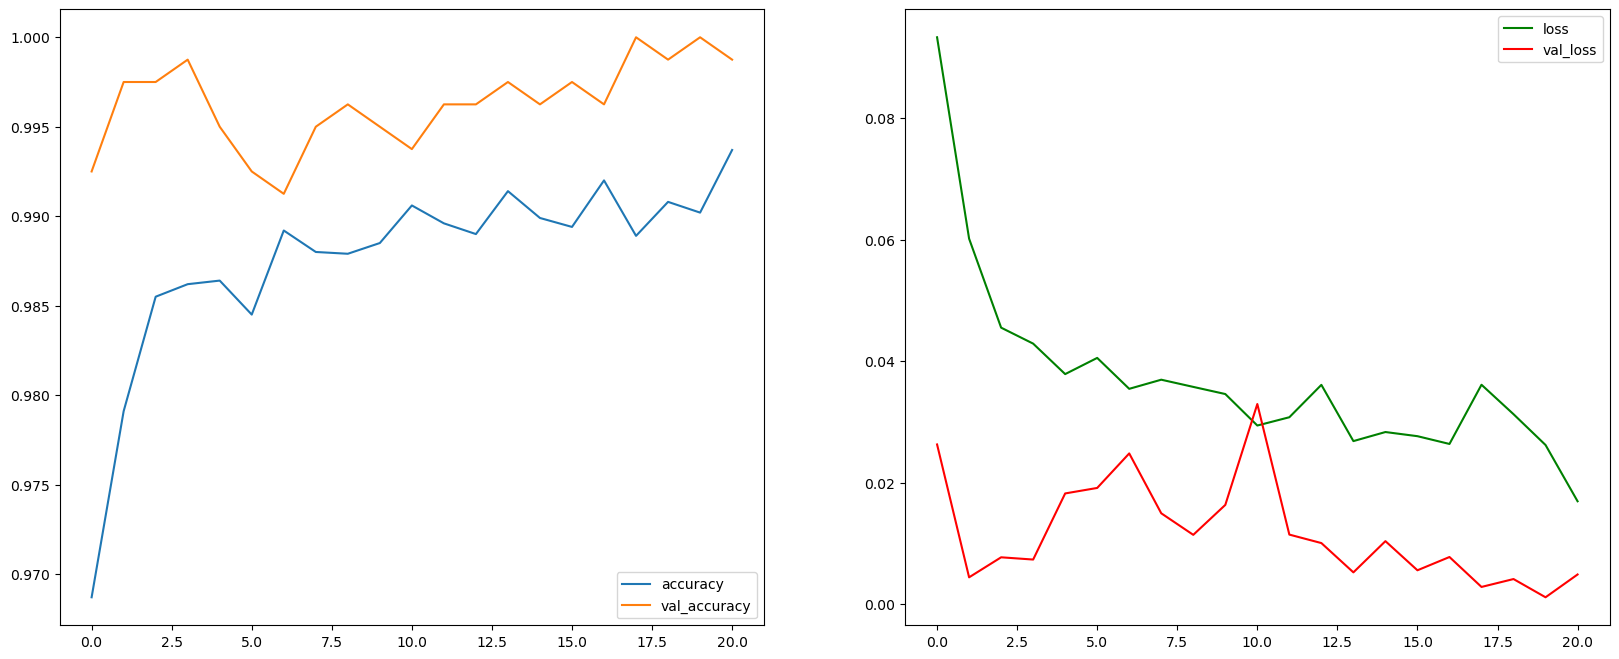

In [25]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,8))
ax[0].plot(history.history['accuracy'],)
ax[0].plot(history.history['val_accuracy'])
ax[0].legend(['accuracy', 'val_accuracy'])
ax[1].plot(history.history['loss'], color='g')
ax[1].plot(history.history['val_loss'], color='r')
ax[1].legend(['loss', 'val_loss'])
plt.savefig('plot.png')